In [1]:
import numpy as np
import tqdm
import seaborn as sns
import pandas as pd
import pickle
N, D = 20000, 5
data = np.random.normal(size=(N,D))
data.shape
noise = lambda : np.random.uniform(-1, 1, size=N) / 40
y0 = data[:,1]*data[:,2] + data[:,4] + noise()
y1 = np.where(data[:,0] > 0, data[:,3], data[:,2]) + data[:,1]/2 + noise()
data = np.hstack((data, y0[:,None], y1[:,None]))
_, D1 = data.shape

#data = (data + 3) / 8
data.shape


pickle.dump(data, open( "data.pckl", "wb" ) )

In [2]:
!pwd
!ls -lh

/content
total 1.1M
-rw-r--r-- 1 root root 1.1M Mar  5 11:52 data.pckl
drwxr-xr-x 1 root root 4.0K Mar  3 14:19 sample_data


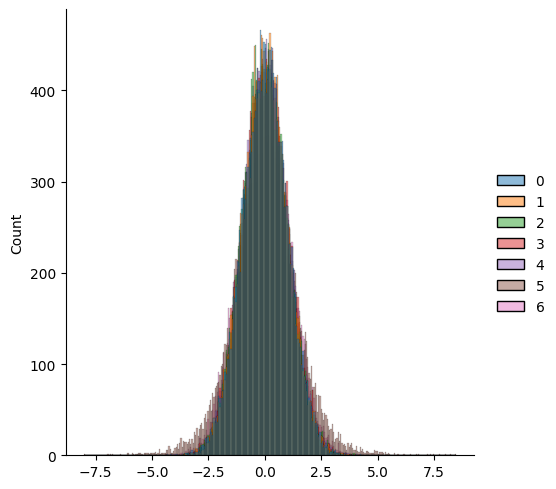

In [3]:

sns.displot(data=data)


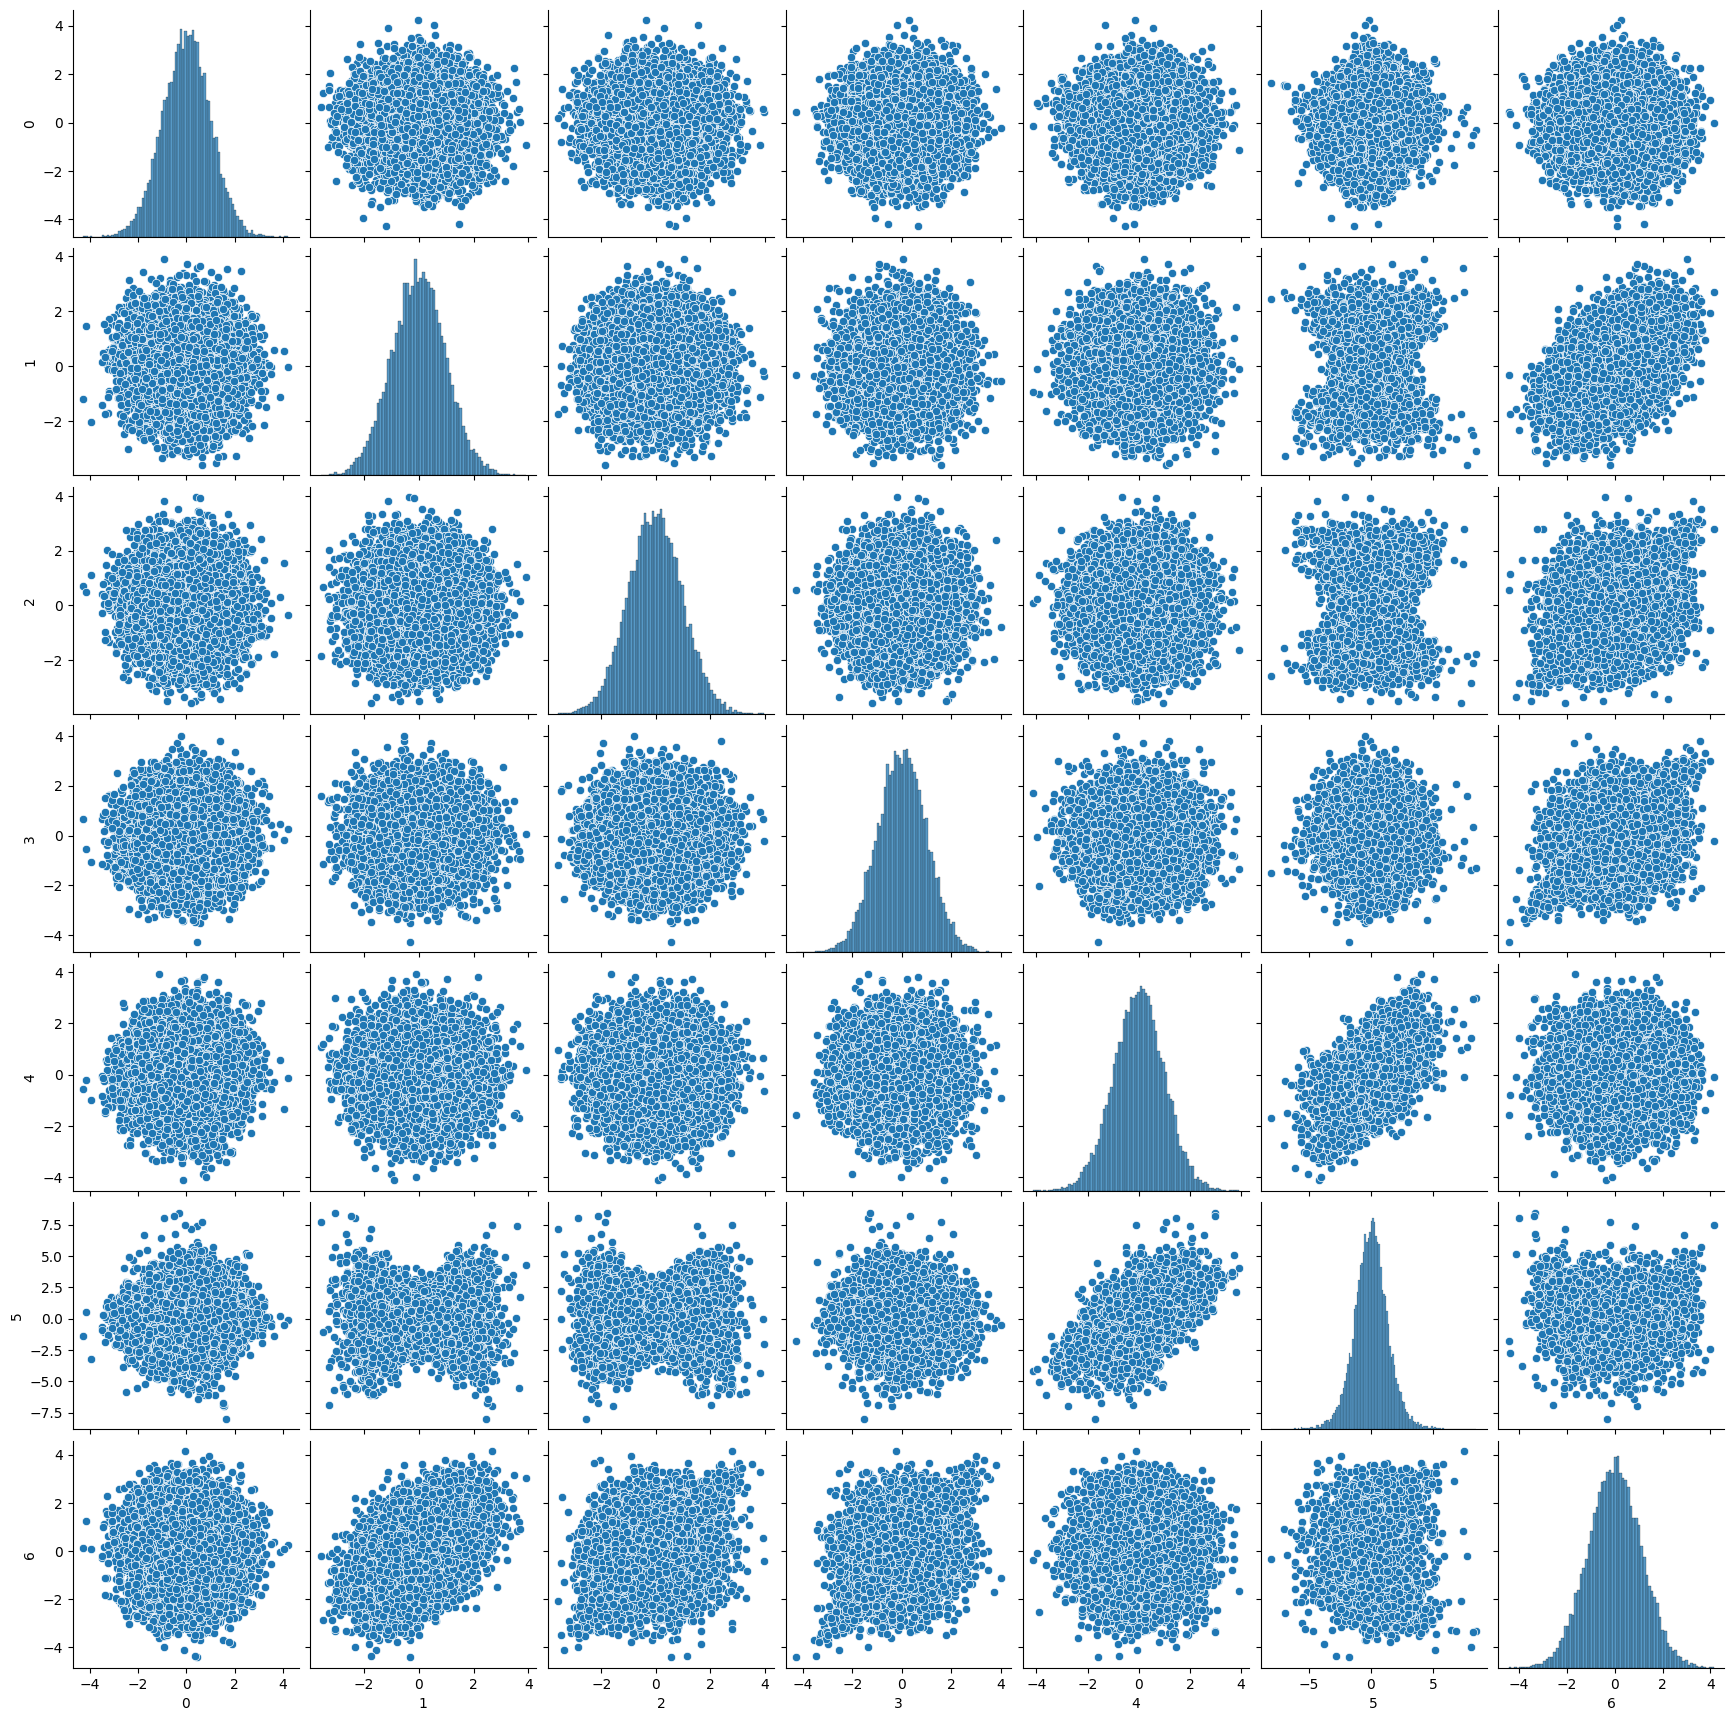

In [4]:
df = pd.DataFrame(data)
sns.pairplot(data=df)

In [13]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

II, J = D1-2, 100
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(D1, J),
            torch.nn.ReLU(),
            torch.nn.Linear(J, J),
            torch.nn.ReLU(),
            torch.nn.Linear(J, J),
            torch.nn.ReLU(),
            torch.nn.Linear(J, J),
            torch.nn.ReLU(),
            torch.nn.Linear(J, J),
            torch.nn.ReLU(),
            torch.nn.Linear(J, J),
            torch.nn.ReLU(),
            torch.nn.Linear(J, II)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(II, J),
            torch.nn.ReLU(),
            torch.nn.Linear(J, J),
            torch.nn.ReLU(),
            torch.nn.Linear(J, J),
            torch.nn.ReLU(),
            torch.nn.Linear(J, J),
            torch.nn.ReLU(),
            torch.nn.Linear(J, J),
            torch.nn.ReLU(),
            torch.nn.Linear(J, D1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [14]:
from torch.utils.data import TensorDataset, DataLoader

Nt = 2 * N // 3
Nv = N - Nt

Xt = TensorDataset(torch.Tensor(data[:Nt, :]))
loader_t = DataLoader(Xt, batch_size=1000)
Xv = TensorDataset(torch.Tensor(data[Nt:, :]))
loader_v = DataLoader(Xv, batch_size=1000)


In [15]:
def todev(f) : return f.cuda()
#def todev(f) : return f.cpu()


In [16]:
model = todev(AE())

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-2/2,
                             weight_decay = 1e-7)

In [17]:
epochs = 200
outputs = []
losses = []
losses_v = []
for epoch in tqdm.tqdm(range(epochs)):
	def ftrain(v, train=True) :
		d = todev(v[0])
		reconstructed = model(d)
		loss = loss_function(reconstructed, d)
		if train :
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
		return loss.detach().cpu()
	losses.append(np.mean([ftrain(v) for v in loader_t]))
	losses_v.append(np.mean([ftrain(v, False) for v in loader_v]))



100%|██████████| 200/200 [00:28<00:00,  7.04it/s]


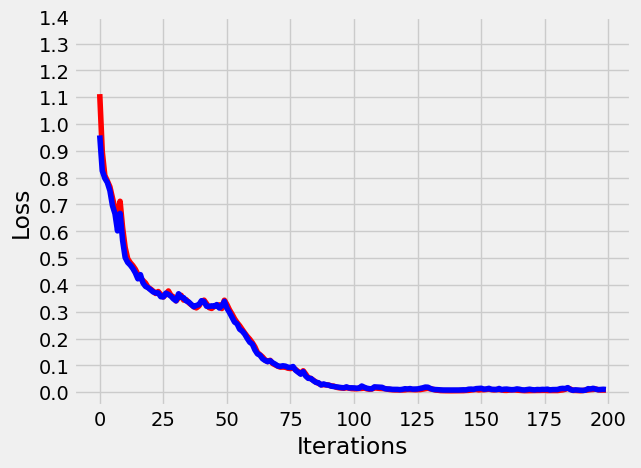

In [18]:

plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.plot(range(len(losses)), losses, 'red', losses_v, 'blue')
_=plt.yticks(np.arange(0, 1.5, 0.1))